# 13. Frame Selected Stability

In [5]:
from src import *

## Description

We look in this section for the stability of frame selected gradients across subjects (individual gradients approach) and also how stable the group gradients are when frame selecting compared to when full is used. 

GOAL: Evaluate differences of individual gradients of selected gradients and movie long gradients + evaluate differences of group gradients of selected timeseries and group gradients of full movies 

## Table of Contents
- [Frame selected (by discrete emotion timecourses) gradients](#discreteemo)
- [Frame selected (by 3FA timecourses) gradients](#3fa)

In [6]:
mri_path400 = "./data/fmri414_compiled/"

<a class="anchor" id="discreteemo"></a>
## Frame selected (by discrete emotion timecourses) gradients

In [7]:
# In-Tervals percentages
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

### Gradients Computation

In [8]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

threshed_series = load('./resources/treshed_series.pkl')

1. Frame selection compute

In [56]:
for i in range(4):
    # individual variance variables
    fselect_subjects_gradients = {}
    
    threshed = threshed_series[i]
    for rng in tqdm(threshed.keys()):
        selected_series = threshed[rng]

        # concatenate on different frames across movies
        # basically doing reordering of columns
        tmp = next(iter(selected_series))
        subject_numbers = list(selected_series[tmp].keys())
        subject_tmpseries = {_id:[] for _id in subject_numbers}

        for mname in selected_series:
            if len(selected_series[mname]) == 0: continue
            for _id in subject_numbers:
                subject_tmpseries[_id].append(selected_series[mname][_id])

        subject_series = []
        for _id in subject_numbers:
            subject_series.append(np.concatenate(subject_tmpseries[_id]))

        # if concatenated length not long enough then skip whole process
        if len(subject_series[0]) < 15: 
            fselect_subjects_gradients[rng] = []
            continue

        # Compute individual gradients according to selected frames
        subjects_gradients = []
        for nsub in range(len(subject_numbers)):
            tmp_series = np.asarray(subject_series)[nsub]
            fc_selects = FC(tmp_series)
            g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                                kernel=aff_kernel, random_state=rs)
            g_selects.fit(fc_selects)
            subjects_gradients.append(g_selects.gradients_)

        # alignement across all gradients
        select_subjects_gradients,_,s = procrustes_align(np.asarray(subjects_gradients))
        select_subjects_gradients = np.asarray(select_subjects_gradients)
        fselect_subjects_gradients[rng] = select_subjects_gradients

    save('./resources/fselect_subjects_gradients{}.pkl'.format(i), fselect_subjects_gradients)

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

2. Compute Null samples of various length

In [634]:
# Also doing sampling of a given percentage in each series equally 
# instead of over everything (so we necessarily have balanced per movie length)
bounds = {10: s10, 20: s20, 25:s25, 33:s33, 50:s50}
selected_series = load('./data/fmri_414_series.pkl')

for nullperc in [20]:
    TMP = []
    np.random.seed(19)
    
    for _ in tqdm(range(100)):
        normalize_subjects_gradients = {}
            
        # concatenate on different frames across movies
        # basically doing reordering of columns
        tmp = list(selected_series.values())
        subject_numbers = [l for l in list(tmp[0].keys())]
        bins = bounds[nullperc]
        
        
        bound_subject_tmpseries = {boun: {_id:[] for _id in subject_numbers} for boun in bins}

        for i in range(len(tmp)):
            if len(tmp[i]) == 0: continue

            length = tmp[i][subject_numbers[0]].shape[0]
#             sampleidx = np.random.choice(np.arange(length), 
#                                      length*nullperc//100, replace=False)  
            cur_idx = np.arange(length)
            np.random.shuffle(cur_idx)
            
            for boun in bins:
                for _id in subject_numbers:
                    lb,rb = boun
                    lb,rb = int(length * lb/100), int(length * rb/100)
                    shuffled_series = tmp[i][_id][cur_idx]
                    bound_subject_tmpseries[boun][_id].append(shuffled_series[lb:rb])

                
        for boun in bins:
            subject_tmpseries = bound_subject_tmpseries[boun]
            subject_series = []
            
            for _id in subject_numbers:
                sample = np.concatenate(subject_tmpseries[_id])
                subject_series.append(sample)

            # Compute individual gradients according to selected frames
            subjects_gradients = []
            for nsub in range(len(subject_numbers)):
                tmp_series = np.asarray(subject_series)[nsub]
                fc_selects = FC(tmp_series)
                g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                                    kernel=aff_kernel, random_state=rs)
                g_selects.fit(fc_selects)
                subjects_gradients.append(g_selects.gradients_)

            # alignement across all gradients
            subjects_gradients,_,s = procrustes_align(np.asarray(subjects_gradients))
            subjects_gradients = np.asarray(subjects_gradients)
            normalize_subjects_gradients[boun] = subjects_gradients

        TMP.append(normalize_subjects_gradients)

    save('./resources/null_grad/sample_bins/nulldistrib_random{}.pkl'.format(nullperc), TMP)

  0%|          | 0/100 [00:00<?, ?it/s]

3. Rest Film Gradients Computation 

In [21]:
# bootstrap variables
sample_size = 25
resample_nb = 100

mri_df = pd.read_csv(mri_path400 + 'Rest_compiled414.csv')
front_pad = 0
end       = -1

rest_subject_series = []
rest_subjects_gradients = []
acqui        = [k for k in mri_df.filename.unique() if '414' in k]

# Individual gradients computation
for filename_movie in acqui:
    tmp_series, _ = df_to_timeseries(mri_df, filename_movie)

    tmp_series    = tmp_series[front_pad : end]
    fc = FC(tmp_series)
    g = GradientMaps(n_components=nb_comp, approach=embedding, 
                            kernel=aff_kernel, random_state=rs)
    g.fit(fc)
    rest_subjects_gradients.append(g.gradients_)    
    rest_subject_series.append(tmp_series)

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
rest_subjects_gradients,_,s = procrustes_align(np.asarray(rest_subjects_gradients))
rest_subjects_gradients = np.asarray(rest_subjects_gradients)

### Evaluate By eyeballing

In [318]:
D = lambda x,y: ((x-y)**2).sum(axis=1)

## Scoring 1

In [319]:
fselect_subjects_gradients = load('./resources/fselect_subjects_gradients1.pkl')

In [122]:
# threshed_df = {}
# orig_df = {}
# null_df = {}
# for bounds in tqdm(fselect_subjects_gradients):
#     tdf = {}
#     odf = {}
#     ndf = {}
    
#     lb,rb = bounds
#     ssize = str(rb-lb)
#     TMP = load('./resources/null_grad/sample_permovie/nulldistrib_random{}.pkl'.format(ssize))
    
#     A = []
#     for i in range(500):
#         tmp = np.asarray([D(TMP[i][ssize].mean(axis=1)[k],TMP[i][ssize][k]) for k in range(30)])
#         A.append(tmp.std(axis=0))

#     fscore = np.asarray([D(fselect_subjects_gradients[bounds].mean(axis=1)[k],
#               fselect_subjects_gradients[bounds][k]) for k in range(30)])
    
#     odf['fullnet'] = fscore.std(axis=0)
#     fscore = fscore.std(axis=0).mean(axis=0)
#     # nscore = null_score(A,fscore)
#     tdf['fullnet'] = fscore
#     ndf['fullnet'] = A
    
    
    
#     for region in index2region.keys():
#         A = []
#         for i in range(500):
#             tmp = np.asarray([D(TMP[i][ssize][k].mean(axis=0),
#                                 TMP[i][ssize][k,index2region[region]]) for k in range(30)])
#             A.append(tmp.std(axis=0))

#         fscore = np.asarray([D(fselect_subjects_gradients[bounds][k].mean(axis=0),
#               fselect_subjects_gradients[bounds][k,index2region[region]]) for k in range(30)])
        
#         odf[region] = fscore.std(axis=0)
#         fscore = fscore.std(axis=0).mean(axis=0)
#         # nscore = null_score(A,fscore)
#         tdf[region] = fscore
#         ndf[region] = A
        
#     threshed_df[bounds] = tdf
#     orig_df[bounds] = odf
#     null_df[bounds] = ndf
# threshed_df = pd.DataFrame.from_records(threshed_df)
# orig_df = pd.DataFrame.from_records(orig_df)
# null_df = pd.DataFrame.from_records(null_df)

  0%|          | 0/24 [00:00<?, ?it/s]

In [637]:
orig_df = {}
null_df = {}
for bounds in tqdm(s20+s25+s33+s50):
    odf = {}
    ndf = {}
    
    lb,rb = bounds
    ssize = str(rb-lb)
    if ssize == '34': ssize='33' # ssizeck fix

    TMP = load('./resources/null_grad/sample_bins/nulldistrib_random{}.pkl'.format(ssize))
    
    A = []
    if ssize == '20':
        n_iter = 100
    else:
        n_iter = 200
    for i in range(n_iter):
        tmp = np.asarray([D(TMP[i][bounds].mean(axis=1)[k],TMP[i][bounds][k]) for k in range(30)])
        A.append(tmp.std(axis=0))

    fscore = np.asarray([D(fselect_subjects_gradients[bounds].mean(axis=1)[k],
              fselect_subjects_gradients[bounds][k]) for k in range(30)])
    
    odf['fullnet'] = fscore.std(axis=0)
    ndf['fullnet'] = A
    
    for region in index2region.keys():
        A = []
        for i in range(n_iter):
            tmp = np.asarray([D(TMP[i][bounds][k].mean(axis=0),
                                TMP[i][bounds][k,index2region[region]]) for k in range(30)])
            A.append(tmp.std(axis=0))

        fscore = np.asarray([D(fselect_subjects_gradients[bounds][k].mean(axis=0),
              fselect_subjects_gradients[bounds][k,index2region[region]]) for k in range(30)])
        
        odf[region] = fscore.std(axis=0)
        ndf[region] = A
        
    orig_df[bounds] = odf
    null_df[bounds] = ndf

orig_df = pd.DataFrame.from_records(orig_df)
null_df = pd.DataFrame.from_records(null_df)

  0%|          | 0/14 [00:00<?, ?it/s]

Compute slope and locate in null distrib slope 1

In [193]:
from sklearn.linear_model import LinearRegression

In [272]:
# B = s50

# perdf = np.asarray([orig_df[B].iloc[0][k] for k in range(len(orig_df[B].columns))]).T
# nperdf = np.asarray([null_df[B].iloc[0][k] for k in range(len(null_df[B].columns))])

# # initial statistic
# y_train = np.concatenate([perdf[index2region['Vis']][:,i] - perdf[index2region['Vis']].mean(axis=1) 
#                           for i in range(len(B))])
# X_train = np.concatenate([index2region['Vis'].shape[0] * [i] for i in range(len(B))])

# regressor = LinearRegression()
# regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
# initial_coef = regressor.coef_[0][0]

# intercept = regressor.intercept_


# # null statistics
# np.random.seed(19)
# null_distrib = []
# null_intercepts = []
# for _ in range(200):
#     tmpdf = nperdf[0][np.random.choice(np.arange(500), len(B), replace=False)].T

#     y_train = np.concatenate([tmpdf[index2region['Vis']][:,i] - tmpdf[index2region['Vis']].mean(axis=1) 
#                               for i in range(len(B))])
#     X_train = np.concatenate([index2region['Vis'].shape[0] * [i] for i in range(len(B))])
#     regressor = LinearRegression()
#     regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
#     null_coef = regressor.coef_[0][0]
#     null_distrib.append(null_coef)
#     null_intercepts.append(regressor.intercept_)
    
# null_distrib = np.array(null_distrib)
# null_intercepts = np.array(null_intercepts)

# null_score(null_distrib, initial_coef)

Compute slope and locate in null distrib slope 2

In [672]:
# save('varmap75100.pkl',orig_df[(75,100)].iloc[0])
# save('varmap80100.pkl',orig_df[(80,100)].iloc[0])

In [659]:
nscores = {B[0][1]-B[0][0]: {} for B in [s20, s25, s33, s50]}
for B in [s20, s25, s33, s50]:
    for net in index2region.keys():
        subset = np.arange(len(B))
        # subset = [1,2]

        perdf = np.asarray([orig_df[B].iloc[0][k] for k in range(len(orig_df[B].columns))]).T
        nperdf = np.asarray([null_df[B].iloc[0][k] for k in range(len(null_df[B].columns))])
        
        # 1. Compute initial statistic
        y_train = np.concatenate([perdf[index2region[net]][:,i] - perdf[index2region[net]].mean(axis=1) 
                                  for i in subset])
        X_train = np.concatenate([index2region[net].shape[0] * [i] for i in range(len(subset))])

        regressor = LinearRegression()
        regressor.fit(X_train.reshape(-1,1), y_train)
        initial_coef = regressor.coef_[0]

        intercept = regressor.intercept_

        # 2. Generate null statistics
        null_distrib = []
        null_intercepts = []
        if B[0][1]-B[0][0] == 20:
            n_iter = 100
        else:
            n_iter = 200

        for k in range(n_iter):
            tmpdf = nperdf[:,k].T
            y_train = np.concatenate([tmpdf[index2region[net]][:,i] - tmpdf[index2region[net]].mean(axis=1) 
                                      for i in subset])
            X_train = np.concatenate([index2region[net].shape[0] * [i] for i in range(len(subset))])
            regressor = LinearRegression()
            regressor.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))
            null_coef = regressor.coef_[0][0]
            null_distrib.append(null_coef)
            null_intercepts.append(regressor.intercept_)

        null_distrib = np.array(null_distrib)
        null_intercepts = np.array(null_intercepts)

        # 3. Compute null score
        nscores[B[0][1]-B[0][0]][net] = null_score(null_distrib, initial_coef)

In [660]:
pd.DataFrame.from_records(nscores)

,20,25,33,50
Vis,0.21,0.105,0.100,0.095
SomMot,0.35,0.270,0.420,0.440
DorsAttn,0.03,0.045,0.045,0.010
SalVentAttn,0.50,0.455,0.395,0.290
Limbic,0.26,0.320,0.115,0.335
Cont,0.33,0.515,0.455,0.170
Default,0.39,0.405,0.355,0.265
Sub,0.27,0.325,0.225,0.375


Visualize standard deviations

/tmp/ipykernel_182065/3961030576.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels([str(b) for b in B])
/tmp/ipykernel_182065/3961030576.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[idx+1].set_xticklabels([str(b) for b in B])


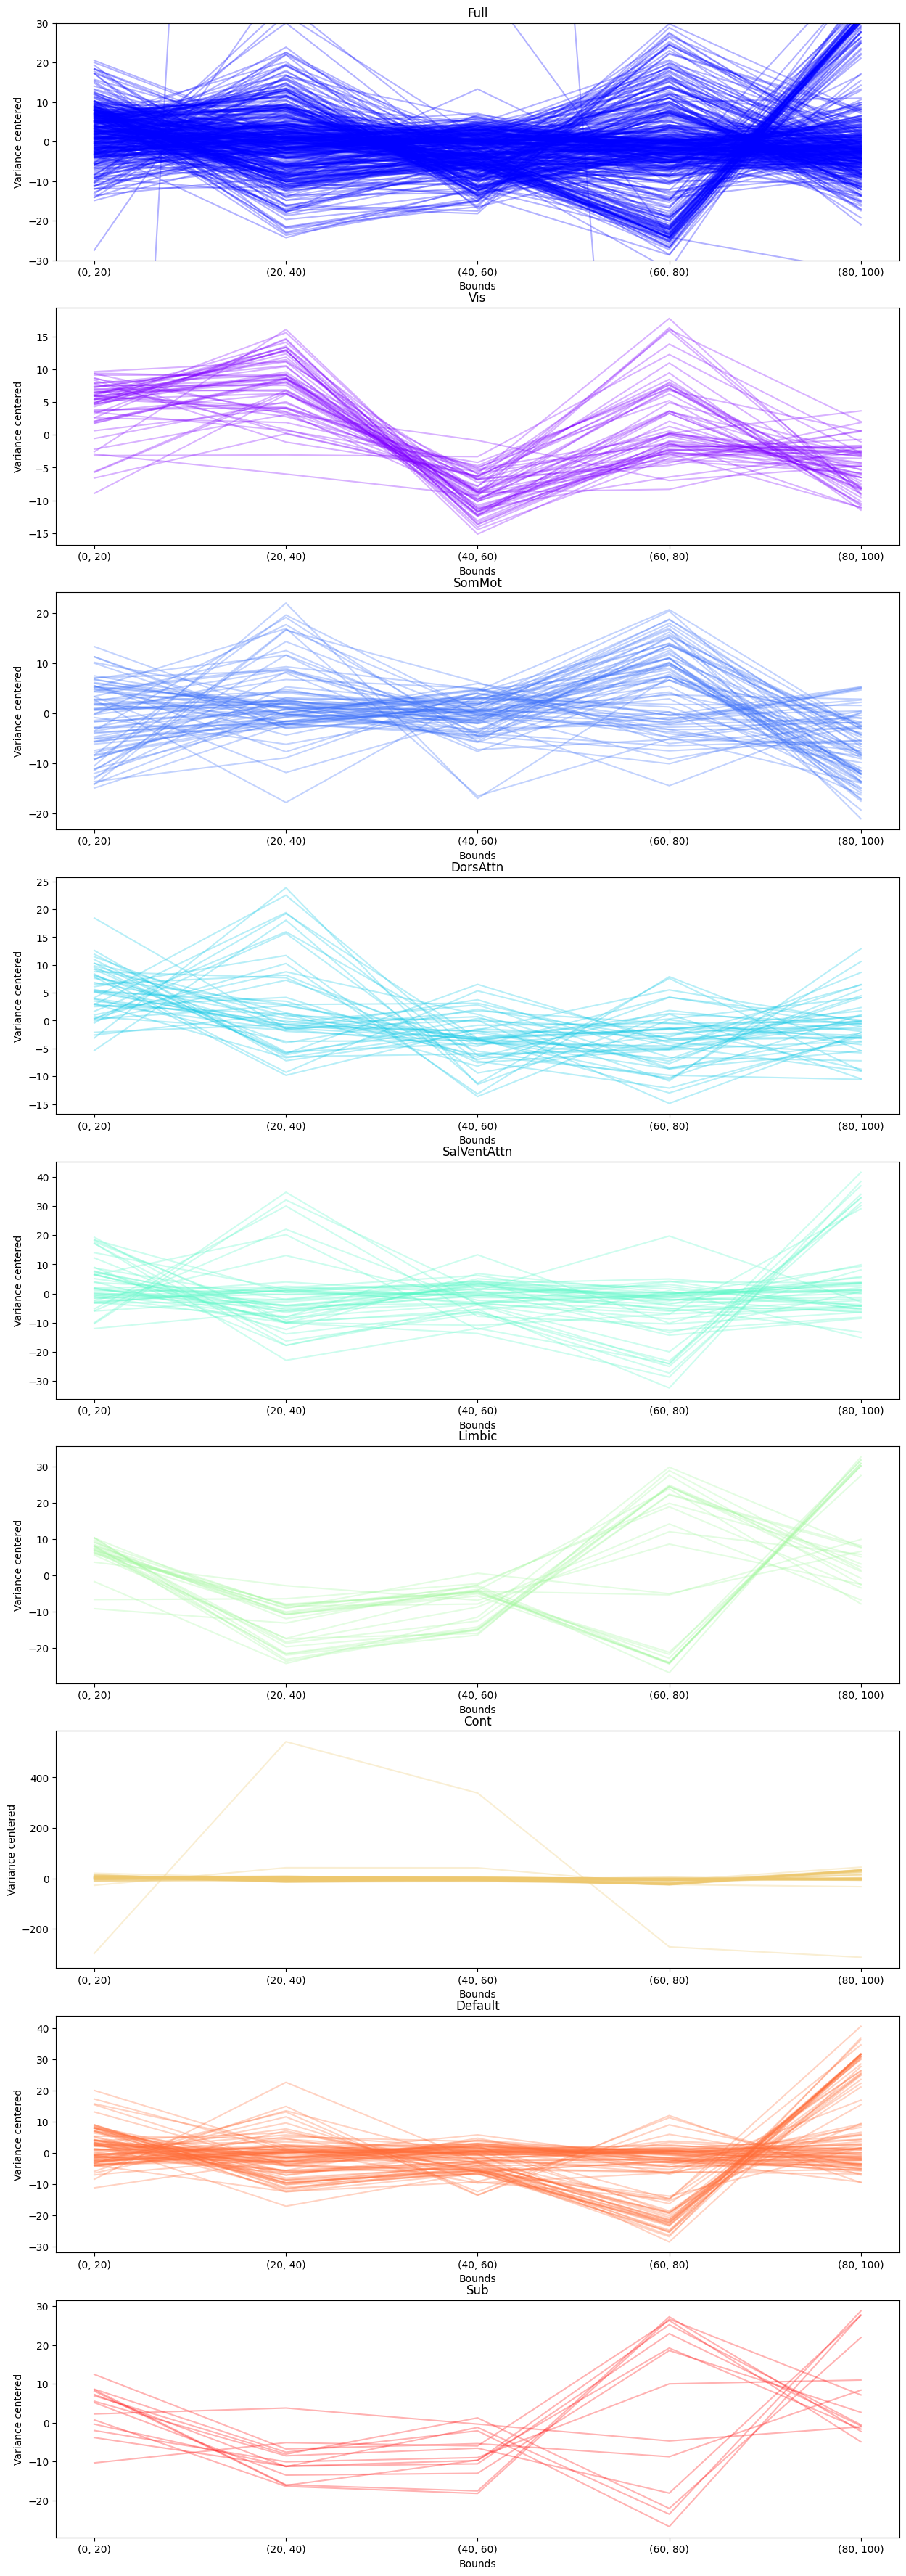

In [647]:
from matplotlib.pyplot import cm

color = cm.rainbow(np.linspace(0, 1, len(index2region)))

fig, ax = plt.subplots(len(index2region)+1,1, figsize=(15,45))
for ridx in range(len(perdf)):
    ax[0].plot(perdf[ridx]-perdf[ridx].mean(), color='b', alpha=0.3)
    ax[0].set_ylim(-30,30)
    ax[0].set_title('Full')
    ax[0].set_xticklabels([str(b) for b in B])
    ax[0].set_xticks(np.arange(0,len(B)))
    ax[0].set_xlabel('Bounds')
    ax[0].set_ylabel('Variance centered')
    
for idx,net in enumerate(index2region):
    region_idx = index2region[net]
    for ridx in region_idx:
        ax[idx+1].set_title(net)
        ax[idx+1].plot(perdf[ridx]-perdf[ridx].mean(), color=color[idx], alpha=0.3)
    ax[idx+1].set_xticklabels([str(b) for b in B])
    ax[idx+1].set_xticks(np.arange(0,len(B)))
    ax[idx+1].set_xlabel('Bounds')
    ax[idx+1].set_ylabel('Variance centered')
#     if net == 'DorsAttn':
#         ax[idx+1].set_ylim(-10,12)
#     if net == 'Cont':
#         ax[idx+1].set_ylim(-10,12)

In [ ]:
df = {'bound': [], 'var': [], 'type': [], 'class': []}

for ridx,region in enumerate(list(orig_df.index)):

    s30df = orig_df[s10].iloc[ridx]
    s40df = orig_df[s20].iloc[ridx]
    s50df = orig_df[s25].iloc[ridx]

    for k in range(len(s30df)):
        df['var'] += list(s30df[k])
        df['bound'] += [str(s30df.index[k][0])] * len(list(s30df[k]))
        df['type'] += ['s30'] * len(list(s30df[k]))
        df['class'] += [region] * len(list(s30df[k]))

    for k in range(len(s40df)):
        df['var'] += list(s40df[k])
        df['bound'] += [str(s40df.index[k][0])] * len(list(s40df[k]))
        df['type'] += ['s40'] * len(list(s40df[k]))
        df['class'] += [region] * len(list(s40df[k]))
        
    for k in range(len(s50df)):
        df['var'] += list(s50df[k])
        df['bound'] += [str(s50df.index[k][0])] * len(list(s50df[k]))
        df['type'] += ['s50'] * len(list(s50df[k]))
        df['class'] += [region] * len(list(s50df[k]))

df = pd.DataFrame.from_dict(df)

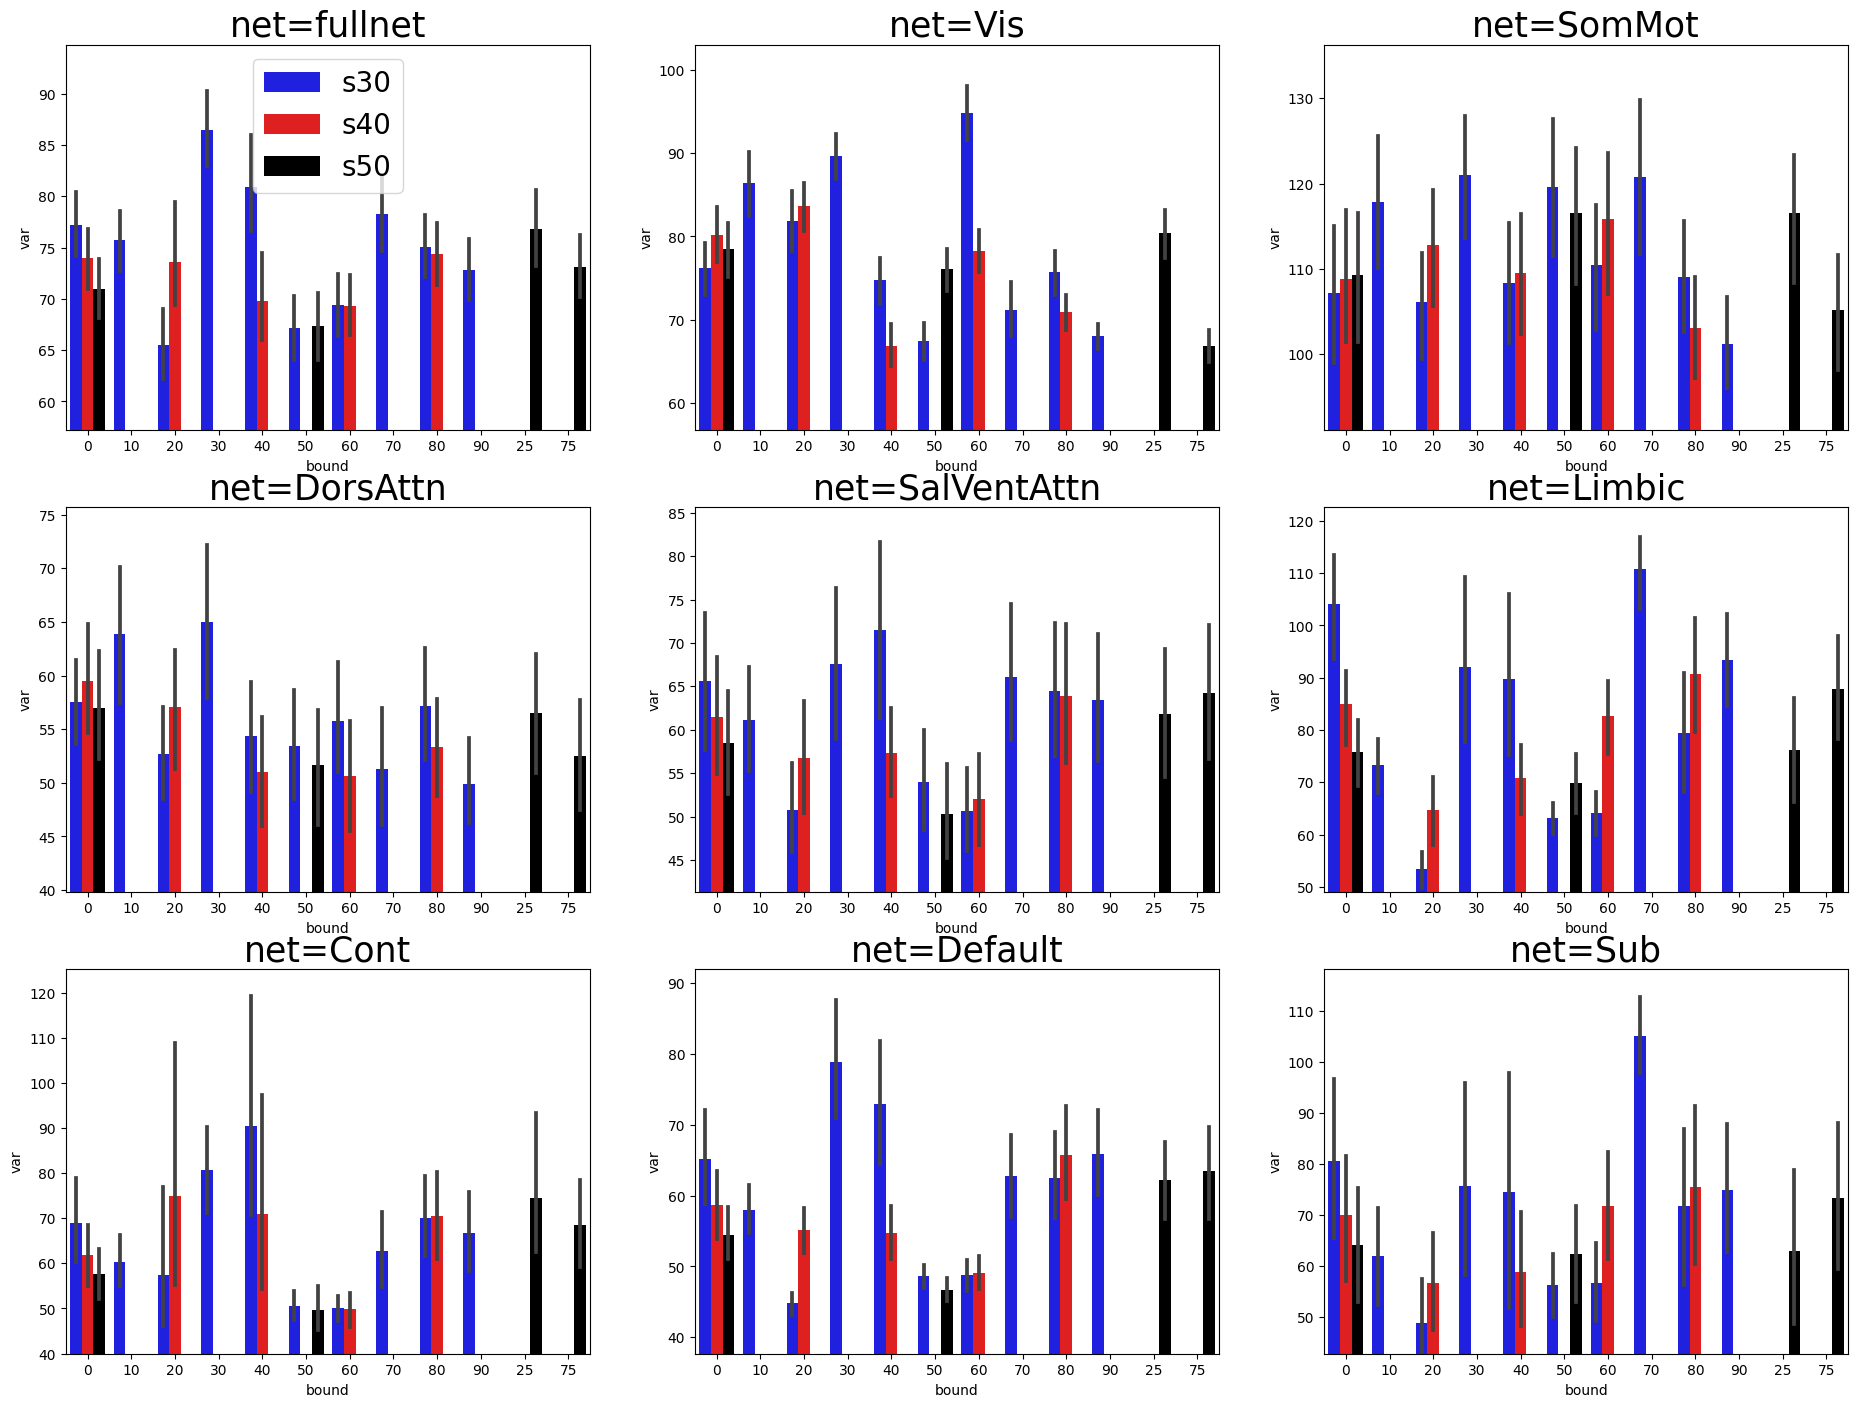

In [19]:
fig, ax = plt.subplots(3, 3, figsize=(23, 17))

for k in range(len(orig_df.index)):
    net = orig_df.index[k]
    r,c = k//3, k%3
    
    low_y = df[df['class'] == net].groupby('bound').mean().min()[0]
    buffer = 10
    
    withlegend = (r==0) and (c==0)
    sns.barplot(x='bound', y='var', data=df[df['class'] == net], ax=ax[r,c], hue='type', 
           palette=sns.color_palette(['blue', 'red', 'black']))
    if not withlegend:
        ax[r,c].legend([], [], frameon=False, prop={'size': 10})
    else:
        ax[r,c].legend(prop={'size': 20})

    ax[r,c].set_title("net={}".format(net), fontsize=25)
    ax[r,c].set_ylim(bottom=low_y-buffer)

In [ ]:
unweighted30 = [np.mean(np.asarray([np.mean(orig_df[bound].iloc[k]) for k in range(1, len(orig_df[bound])) ]))for bound in s30]
unweighted40 = [np.mean(np.asarray([np.mean(orig_df[bound].iloc[k]) for k in range(1, len(orig_df[bound])) ]))for bound in s40]
unweighted50 = [np.mean(np.asarray([np.mean(orig_df[bound].iloc[k]) for k in range(1, len(orig_df[bound])) ]))for bound in s50]
unweighted60 = [np.mean(np.asarray([np.mean(orig_df[bound].iloc[k]) for k in range(1, len(orig_df[bound])) ]))for bound in s60]

/tmp/ipykernel_126456/1606990405.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[x,y].set_xticklabels([10*k for k in range(-1,len(tmp))])
/tmp/ipykernel_126456/1606990405.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[x,y].set_xticklabels([10*k for k in range(-1,len(tmp))])
/tmp/ipykernel_126456/1606990405.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[x,y].set_xticklabels([10*k for k in range(-1,len(tmp))])
/tmp/ipykernel_126456/1606990405.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[x,y].set_xticklabels([10*k for k in range(-1,len(tmp))])
/tmp/ipykernel_126456/1606990405.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[x,y].set_xticklabels([10*k for k in range(-1,len(tmp))])
/tmp/ipykernel_126456/1606990405.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator


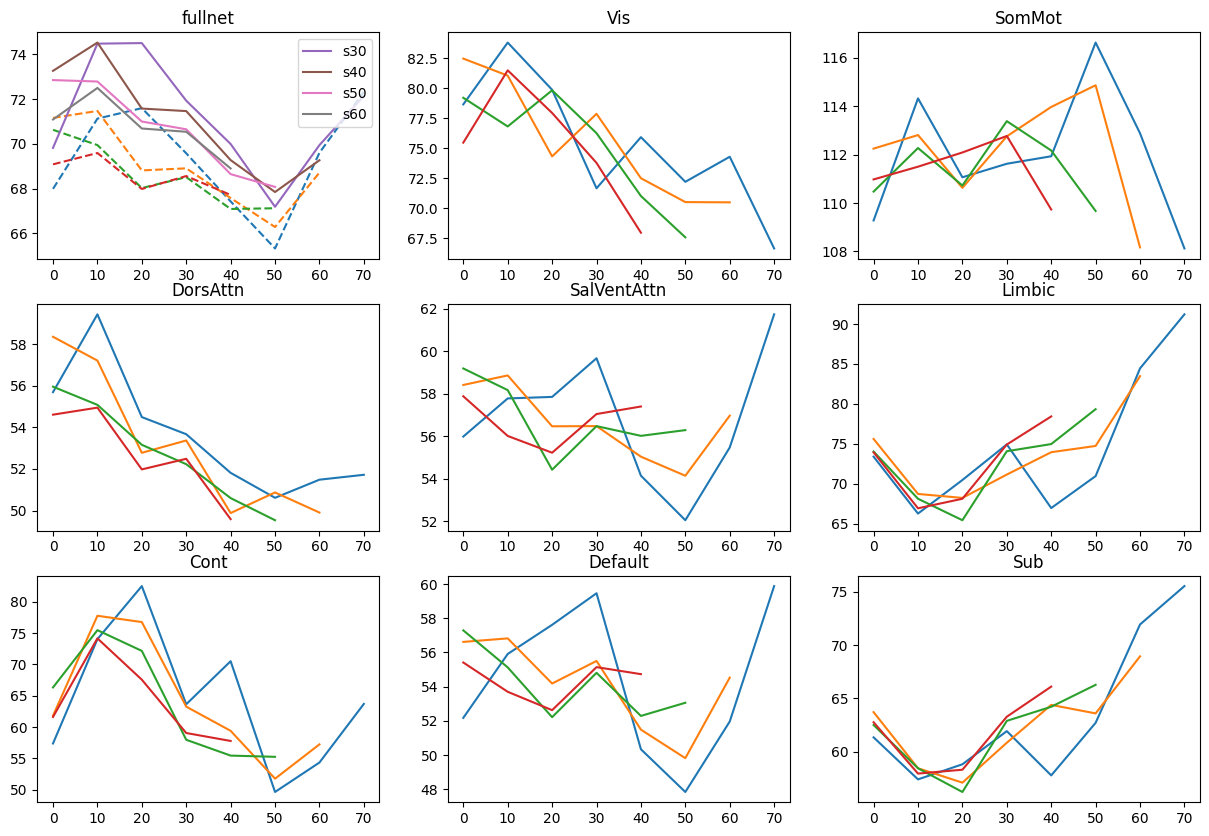

In [38]:
fig , ax = plt.subplots(3,3, figsize=(15,10))
ax[0,0].plot(unweighted30, linestyle='--')
ax[0,0].plot(unweighted40, linestyle='--')
ax[0,0].plot(unweighted50, linestyle='--')
ax[0,0].plot(unweighted60, linestyle='--')
for x in range(3):
    for y in range(3):
        idx = x*3 + y
#         ax[x,y].plot(threshed_df[s10].iloc[idx].values, label='s10')
#         ax[x,y].plot(threshed_df[s20].iloc[idx].values, label='s20')
        ax[x,y].plot(threshed_df[s30].iloc[idx].values, label='s30')
        ax[x,y].plot(threshed_df[s40].iloc[idx].values, label='s40')
        ax[x,y].plot(threshed_df[s50].iloc[idx].values, label='s50')
        ax[x,y].plot(threshed_df[s60].iloc[idx].values, label='s60')
        
        if idx == 0:
            ax[x,y].legend()
        ax[x,y].set_title(list(threshed_df.index)[idx])
        
        tmp = threshed_df[s10].iloc[idx].values
        ax[x,y].set_xticklabels([10*k for k in range(-1,len(tmp))])

<a class="anchor" id="3fa"></a>
## Frame selected (by 3FA timecourses) gradients

In [11]:
# In-Tervals percentages
s10 = [(s,s+10) for s in range(0,101,10) if (s+10 <= 100)]
s20 = [(s,s+20) for s in range(0,101,20) if (s+20 <= 100)]
s25 = [(s,s+25) for s in range(0,101,25) if (s+25 <= 100)]
s33 = [(0,33), (33,66), (66,100)]
s50 = [(0,50), (50,100)]

In [10]:
# Params
embedding  = "dm" # diffusion map
aff_kernel = "pearson" #affinity matrix kernel
align_meth = "procrustes"
n_iter     = 10 # procrustes align number of iteration
nb_comp    = 3
rs         = 99

threshed_series = load('./resources/fa_treshed_series.pkl')

1. Frame selection compute

In [ ]:
for i in range(3):
    # individual variance variables
    fselect_subjects_gradients = {}
    
    threshed = threshed_series[i]
    for rng in tqdm(threshed.keys()):
        selected_series = threshed[rng]

        # concatenate on different frames across movies
        # basically doing reordering of columns
        tmp = next(iter(selected_series))
        subject_numbers = list(selected_series[tmp].keys())
        subject_tmpseries = {_id:[] for _id in subject_numbers}

        for mname in selected_series:
            if len(selected_series[mname]) == 0: continue
            for _id in subject_numbers:
                subject_tmpseries[_id].append(selected_series[mname][_id])

        subject_series = []
        for _id in subject_numbers:
            subject_series.append(np.concatenate(subject_tmpseries[_id]))

        # if concatenated length not long enough then skip whole process
        if len(subject_series[0]) < 15: 
            fselect_subjects_gradients[rng] = []
            continue

        # Compute individual gradients according to selected frames
        subjects_gradients = []
        for nsub in range(len(subject_numbers)):
            tmp_series = np.asarray(subject_series)[nsub]
            fc_selects = FC(tmp_series)
            g_selects = GradientMaps(n_components=nb_comp, approach=embedding, 
                                kernel=aff_kernel, random_state=rs)
            g_selects.fit(fc_selects)
            subjects_gradients.append(g_selects.gradients_)

        # alignement across all gradients
        select_subjects_gradients,_,s = procrustes_align(np.asarray(subjects_gradients))
        select_subjects_gradients = np.asarray(select_subjects_gradients)
        fselect_subjects_gradients[rng] = select_subjects_gradients

    save('./resources/fselect_grads/fa_scores/fselect_subjects_gradientsFA{}.pkl'.format(i), fselect_subjects_gradients)

  0%|          | 0/24 [00:00<?, ?it/s]